<a href="https://colab.research.google.com/github/ginograf/DSF/blob/main/tutorial_Midterm_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Group 3: Gino Graf, Mathias Kissling**

**4. Performe the tutorial**

In [4]:
!pip install rdkit
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

from google.colab import drive
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

# all important packages and libraries that are needed later are imported.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:

HERE = Path(_dh[-1])
DATA = HERE / "data"

# The path is set to the notebook.

In [6]:
df = pd.read_csv(HERE / "kinase.csv", index_col=0)
df = df.reset_index(drop=True)

In [7]:

print("Shape of dataframe : ", df.shape)
df.info()

# The shape of the dataframe is shown and with the info() function the dimension and the dtype of each column is shown.

Shape of dataframe :  (179827, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179827 entries, 0 to 179826
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   molecule_chembl_id  179827 non-null  object 
 1   standard_value      179827 non-null  float64
 2   standard_units      179827 non-null  object 
 3   target_chembl_id    179827 non-null  object 
 4   smiles              179827 non-null  object 
dtypes: float64(1), object(4)
memory usage: 6.9+ MB


In [8]:

chembl_df = df[["smiles", "standard_value"]]
chembl_df["pIC50"] = -np.log10(chembl_df["standard_value"]*0.000000001)
chembl_df = chembl_df.drop(columns=['standard_value'])
chembl_df.head()
# NBVAL_CHECK_OUTPUT

# A new dataframe is created (chembl_df) with only the necessary columns for the machine learning model. The first five rows are again shown with the head() function.

,smiles,pIC50
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.397940
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,4.795880
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,6.096910
3,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.045757
4,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.769551


In [9]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

# The smiles strings are converted to numerical data. 

In [10]:
chembl_df["fingerprints_df"] = chembl_df["smiles"].apply(smiles_to_fp)

In [11]:
print("Shape of dataframe:", chembl_df.shape)
chembl_df.head(3)

Shape of dataframe: (179827, 3)


,smiles,pIC50,fingerprints_df
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.39794,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,4.79588,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,6.09691,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
chembl_df = chembl_df[0:10000]

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

# With the train_test_split() function the dataset is split to a training data, which contains the first 70% of the data, and the test set containing the rest of data. x values are the features (vit vectors) and y the target values.

Shape of training data: (7000,)
Shape of test data: (3000,)


In [13]:
df_test = chembl_df.iloc[125878::,:]
df_test = df_test.drop(columns=["pIC50", "fingerprints_df"])

In [14]:
filepath2 = Path(DATA / 'test.csv')  
filepath2.parent.mkdir(parents=True, exist_ok=True)  
df_test.to_csv(filepath2)

In [22]:
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

# The neural network model is defined with two hidden layers. Then the model was compiled with mean sqaured error as loss function and adam as optimizer.

In [31]:
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 32
layer2_size = 16

# different batch sizes are created.

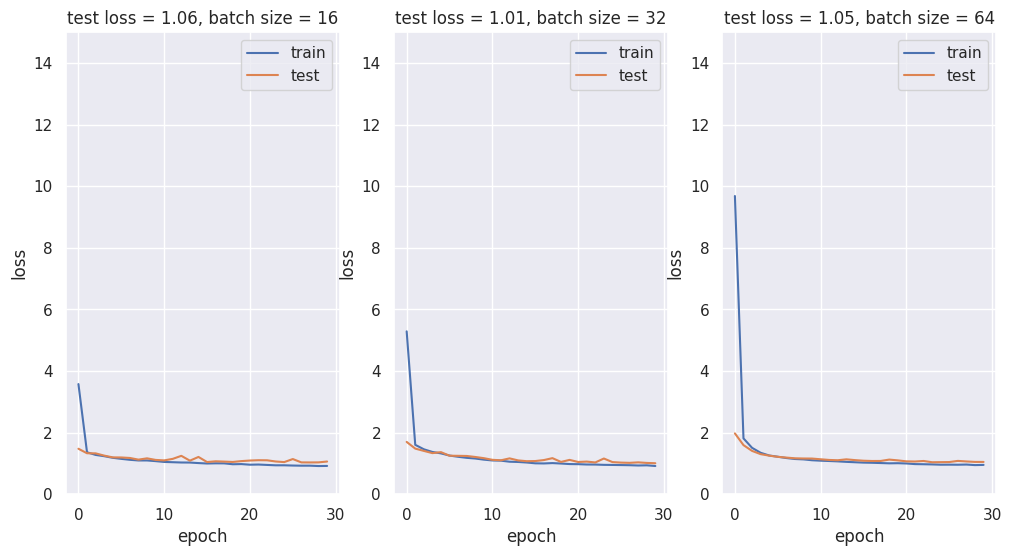

In [32]:

fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()

# The loss functions of the batch sizes are plotted.

In [33]:

filepath = DATA / "best_weights.hdf5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

# The trained model with the best performance is saved. 

In [34]:

print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

# The model's performance is checked and evaluated.

Evaluate the model on the test data
 loss: 1.01
 mse (same as loss): 1.01
 mae: 0.76


In [35]:

y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

# Some values of the test data are predicted. 

94/94 [==============================] - 0s 1ms/step
6.21
6.32
5.63
7.89
5.27


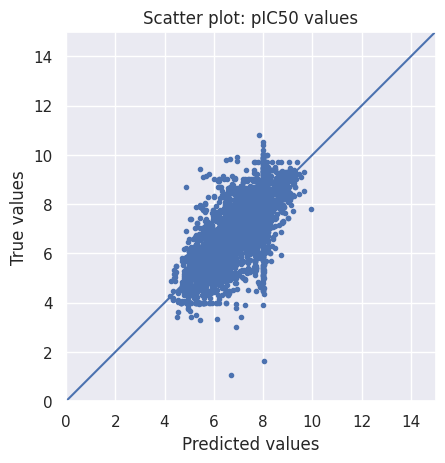

In [36]:

limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()

# The predicted values are plotted against the real values from the test set in a scatter plot to see if the predictions were correct.

In [29]:
# Load external/unlabeled data set
external_data = pd.read_csv(DATA / "test.csv", index_col=0)
external_data = external_data.reset_index(drop=True)
external_data.head()
# NBVAL_CHECK_OUTPUT

,smiles
0,N#Cc1c(N)ncnc1N1CCC(c2nc(-c3ccc(F)c(C(F)(F)F)c...
1,N#Cc1c(N)ncnc1N1CCC(c2nc(-c3ccc(F)c(C(F)(F)F)c...
2,N#Cc1c(N)ncnc1N1CCC(c2nc(-c3ccc(F)c(Cl)c3)cn2C...
3,N#Cc1c(N)ncnc1N1CCC(c2nc(-c3ccc(F)c(Cl)c3)cn2C...
4,N#Cc1c(N)ncnc1N1CCC(c2nc(-c3ccc(OC(F)F)cc3)cn2...


In [ ]:
# Convert SMILES strings to MACCS fingerprints
external_data["fingerprints_df"] = external_data["smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe : ", external_data.shape)
external_data.head(3)
# NBVAL_CHECK_OUTPUT

In [ ]:
model = load_model(DATA / "ANN_model.hdf5", compile=False)

# The model is loaded and saved.

In [ ]:

predictions = model.predict(
    np.array(list((external_data["fingerprints_df"]))).astype(float), callbacks=callbacks_list
)

predicted_pIC50 = pd.DataFrame(predictions, columns=["predicted_standard_value"])
predicted_pIC50_df = external_data.join(predicted_pIC50)

predicted_pIC50_df.head(3)

# The pIC50 values are predicted from the MACCS fingerprints.

4/4 [==============================] - 0s 4ms/step


,smiles,fingerprints_df,predicted_standard_value
10000,Cc1ncnc(Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)c1C#Cc1nc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
10001,Cc1ncnc(Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)c1C#Cc1cc...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
10002,Cc1ncnc(Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)c1C#CCOc1...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN


In [ ]:
predicted_pIC50_df.to_csv(DATA / "predicted_standard_value_df.csv")

# The predicted values are saved in a csv file. 

In [ ]:

predicted_pIC50_df = pd.read_csv(DATA / "predicted_standard_value_df.csv", index_col=0)
top3_drug = predicted_pIC50_df.nlargest(3, "predicted_standard_value")
top3_drug

# The smiles with the highest predicted values are shown.

,smiles,fingerprints_df,predicted_standard_value
10000,Cc1ncnc(Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)c1C#Cc1nc...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0...,NaN
10001,Cc1ncnc(Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)c1C#Cc1cc...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0...,NaN
10002,Cc1ncnc(Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)c1C#CCOc1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0...,NaN


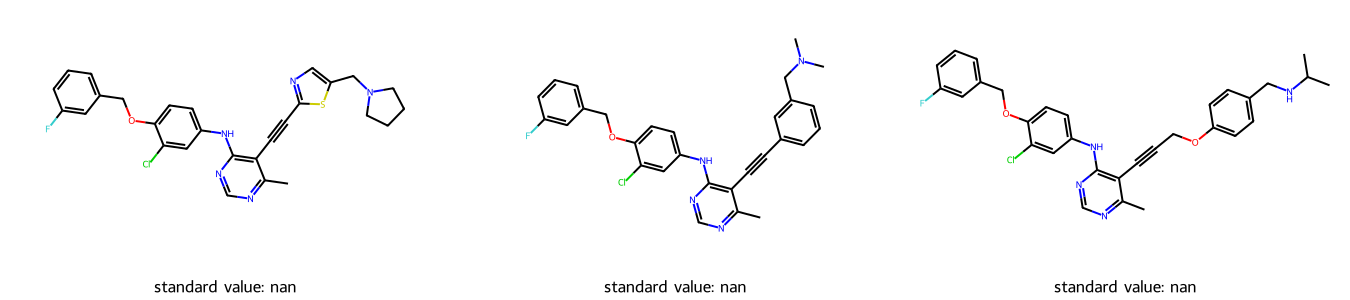

In [ ]:

highest_pIC50 = predicted_pIC50_df["smiles"][top3_drug.index]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pIC50]
pIC50_EGFR = top3_drug["predicted_standard_value"].tolist()
pIC50_values = [(f"standard value: {value:.2f}") for value in pIC50_EGFR]

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pIC50_values)

# The structures of the molecules with the highest predicted values are drawn.